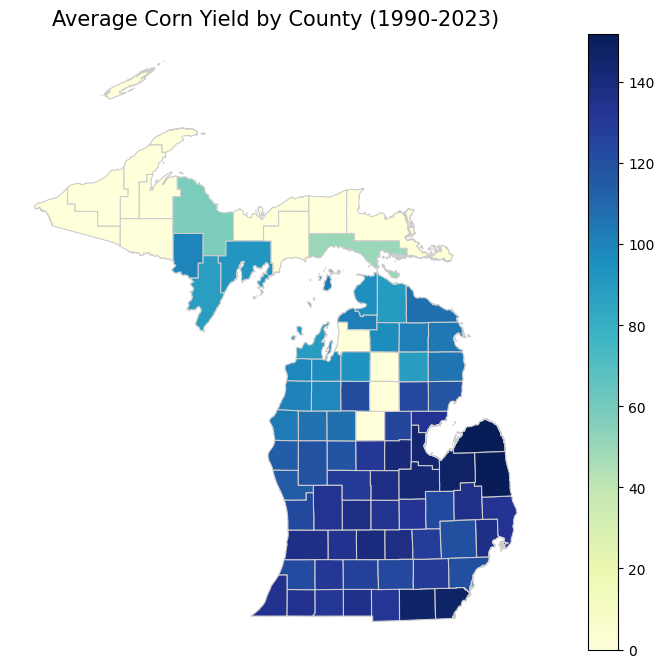

In [45]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load the cleaned merged data (merged_data.csv)
merged_data = pd.read_csv('merged_data.csv')

# Ensure county identifiers are in string format and properly formatted
merged_data['county_ansi'] = merged_data['county_ansi'].astype(int).astype(str).str.zfill(3)
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Calculate average corn yield for each county from merged_data.csv
average_yield = merged_data.groupby('county_ansi')['Value'].mean().reset_index()

# Merge the average yield data back with the GeoDataFrame
merged_gdf = gdf.merge(average_yield, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing yield values by filling NaN with 0 for counties without yield data
merged_gdf['Value'] = merged_gdf['Value'].fillna(0)

# Create a choropleth map of average corn yield by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='Value', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels to the map
plt.title('Average Corn Yield by County (1990-2023)', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()

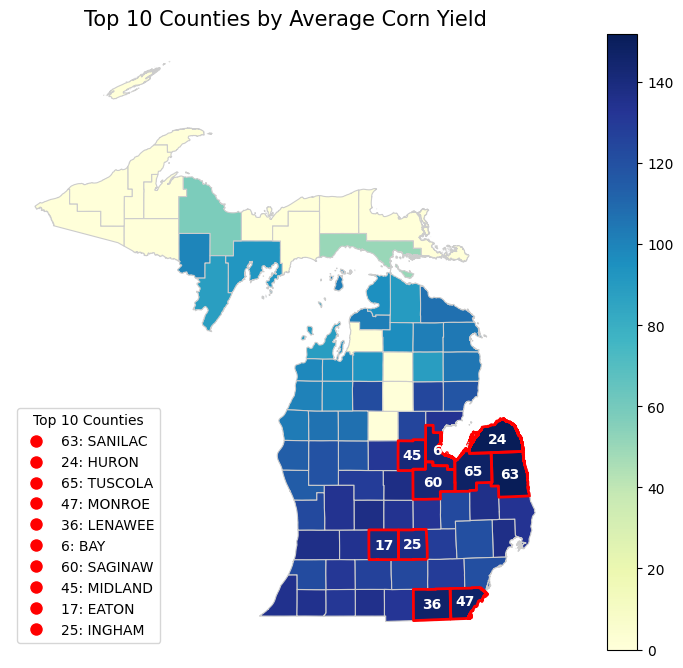

In [46]:
from matplotlib.lines import Line2D

# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load the cleaned merged data (merged_data.csv)
merged_data = pd.read_csv('merged_data.csv')

# Ensure county identifiers are in string format and properly formatted
merged_data['county_ansi'] = merged_data['county_ansi'].astype(int).astype(str).str.zfill(3)
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Calculate average Corn Yield for each county from merged_data.csv
average_yield = merged_data.groupby(['county_ansi', 'county_name'])['Value'].mean().reset_index()

# Get the top 10 counties by average Corn Yield
top_10_yield_counties = average_yield.nlargest(10, 'Value')

# Merge the average yield data back with the GeoDataFrame
merged_gdf = gdf.merge(average_yield, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing Corn Yield values by filling NaN with 0 for counties without yield data
merged_gdf['Value'] = merged_gdf['Value'].fillna(0)

# Create a choropleth map of average Corn Yield by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='Value', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Highlight the top 10 Corn Yield counties with a different edge color and thicker borders
top_10_gdf = merged_gdf[merged_gdf['FIPSCode'].isin(top_10_yield_counties['county_ansi'])]
top_10_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# Add the rank numbers to the map
for idx, row in top_10_gdf.iterrows():
    county_rank = top_10_yield_counties[top_10_yield_counties['county_ansi'] == row['FIPSCode']].index[0] + 1
    centroid = row['geometry'].centroid
    plt.text(centroid.x, centroid.y, str(county_rank), fontsize=10, ha='center', va='center', color='white', weight='bold')

# Create a legend with county names and corresponding ranks
legend_elements = []
for idx, row in top_10_yield_counties.iterrows():
    county_rank = idx + 1
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{county_rank}: {row['county_name']}", 
                                  markerfacecolor='red', markersize=10))

# Add the legend to the map
ax.legend(handles=legend_elements, loc='lower left', title='Top 10 Counties')

# Add titles and labels to the map
plt.title('Top 10 Counties by Average Corn Yield', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()

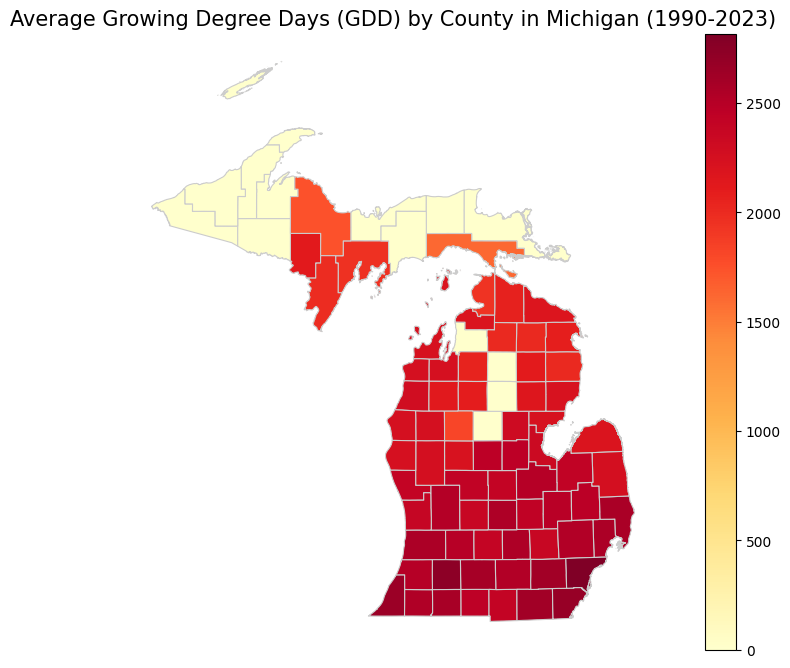

In [47]:
# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load the cleaned merged data (merged_data.csv)
merged_data = pd.read_csv('merged_data.csv')

# Ensure county identifiers are in string format and properly formatted
merged_data['county_ansi'] = merged_data['county_ansi'].astype(int).astype(str).str.zfill(3)
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Calculate average Growing Degree Days (GDD) for each county from merged_data.csv
average_gdd = merged_data.groupby('county_ansi')['GDD'].mean().reset_index()

# Merge the average GDD data back with the GeoDataFrame
merged_gdf = gdf.merge(average_gdd, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing GDD values by filling NaN with 0 for counties without GDD data
merged_gdf['GDD'] = merged_gdf['GDD'].fillna(0)

# Create a choropleth map of average GDD by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='GDD', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels to the map
plt.title('Average Growing Degree Days (GDD) by County in Michigan (1990-2023)', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()

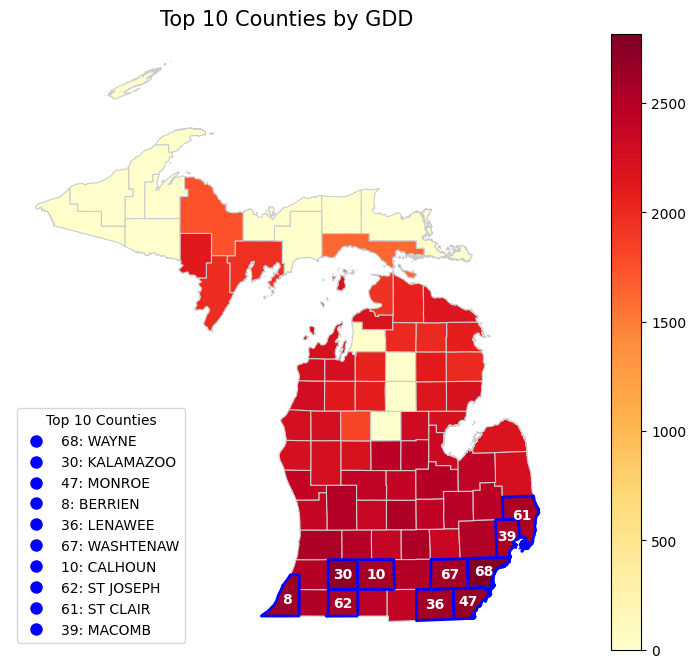

In [49]:
# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load the cleaned merged data (merged_data.csv)
merged_data = pd.read_csv('merged_data.csv')

# Ensure county identifiers are in string format and properly formatted
merged_data['county_ansi'] = merged_data['county_ansi'].astype(int).astype(str).str.zfill(3)
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Calculate average Growing Degree Days (GDD) for each county from merged_data.csv
average_gdd = merged_data.groupby(['county_ansi', 'county_name'])['GDD'].mean().reset_index()

# Get the top 10 counties by average GDD
top_10_gdd_counties = average_gdd.nlargest(10, 'GDD')

# Merge the average GDD data back with the GeoDataFrame
merged_gdf = gdf.merge(average_gdd, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing GDD values by filling NaN with 0 for counties without GDD data
merged_gdf['GDD'] = merged_gdf['GDD'].fillna(0)

# Create a choropleth map of average GDD by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='GDD', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Highlight the top 10 GDD counties with a different edge color and thicker borders
top_10_gdf = merged_gdf[merged_gdf['FIPSCode'].isin(top_10_gdd_counties['county_ansi'])]
top_10_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2)

# Add the rank numbers to the map
for idx, row in top_10_gdf.iterrows():
    county_rank = top_10_gdd_counties[top_10_gdd_counties['county_ansi'] == row['FIPSCode']].index[0] + 1
    centroid = row['geometry'].centroid
    plt.text(centroid.x, centroid.y, str(county_rank), fontsize=10, ha='center', va='center', color='White', weight='bold')

# Create a legend with county names and corresponding ranks
legend_elements = []
for idx, row in top_10_gdd_counties.iterrows():
    county_rank = idx + 1
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{county_rank}: {row['county_name']}", 
                                  markerfacecolor='blue', markersize=10))

# Add the legend to the map
ax.legend(handles=legend_elements, loc='lower left', title='Top 10 Counties')

# Add titles and labels to the map
plt.title('Top 10 Counties by GDD', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()